In [1]:
import numpy as np
import pandas as pd
from plotnine import *
import plotnine
import random
plotnine.options.figure_size = (12, 5)

In [2]:
points=10000
mu=1000
sigma=50
events = pd.concat([
    pd.DataFrame({'event': 'a', 'duration': np.random.normal(mu, sigma, points)}),
    pd.DataFrame({'event': 'b', 'duration': np.random.normal(mu*2, sigma, int(points/2))}),
    pd.DataFrame({'event': 'c', 'duration': np.random.normal(mu*3, sigma, int(points/3))}),
], ignore_index=True)
events

,event,duration
0,a,954.462517
1,a,982.854305
2,a,1037.667967
3,a,1002.143116
4,a,1020.217687
...,...,...
18328,c,3040.239624
18329,c,2941.655774
18330,c,3053.683405
18331,c,2980.200817


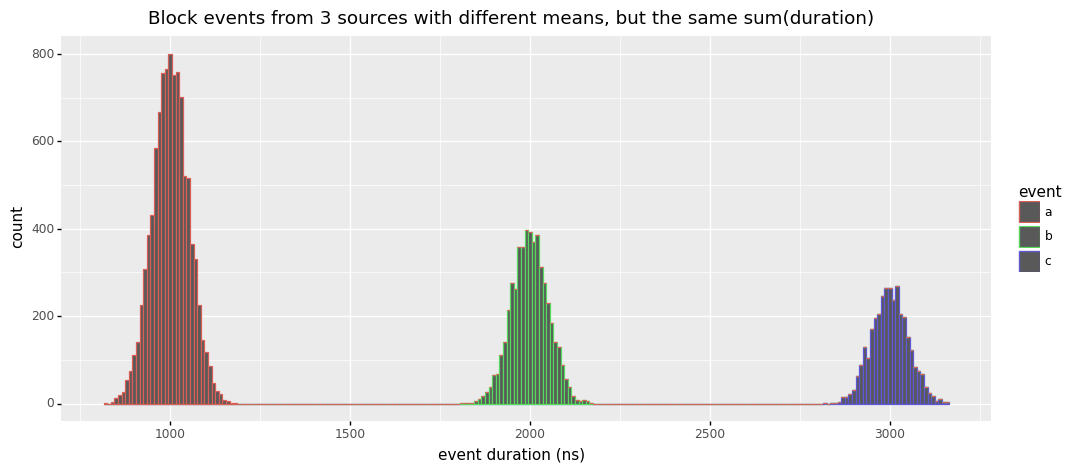

<ggplot: (324948417)>

In [3]:
(
ggplot(events)
+ aes(x='duration',color='event')
+ labs(x='event duration (ns)',title='Block events from 3 sources with different means, but the same sum(duration)')
+ geom_histogram(binwidth=10)
)

In [4]:
# sample implements the sampling used by the go block profiler. Returning 0 is the
# same as false in the go implementation, otherwise the actual number of cycles to
# track is returned. This allows to adjust them for bias if the debias paramter is
# set to True.
#
# 	if rate <= 0 || (rate > cycles && int64(fastrand())%rate > cycles) {
# 		return false
# 	}
# 	return true
def sample(cycles, rate, debias):
    if cycles >= rate:
        return cycles
    elif cycles > 0 and random.getrandbits(64)%rate <= cycles:
        if debias:
            return cycles*(rate/cycles)
        else:
            return cycles
    return 0

def simulate_rates(rates, debias):
    frames = []
    for rate in rates:
        rf = (events
            .groupby('event')['duration']
            .agg(lambda durations: sum(durations.apply(lambda d: sample(d, rate, debias)))).reset_index()
        )
        rf['rate'] = rate
        frames.append(rf)
    return pd.concat(frames)

rates = range(0, 5000, 100)
profiles = simulate_rates(rates, False)
profiles_debiased = simulate_rates(rates, True)

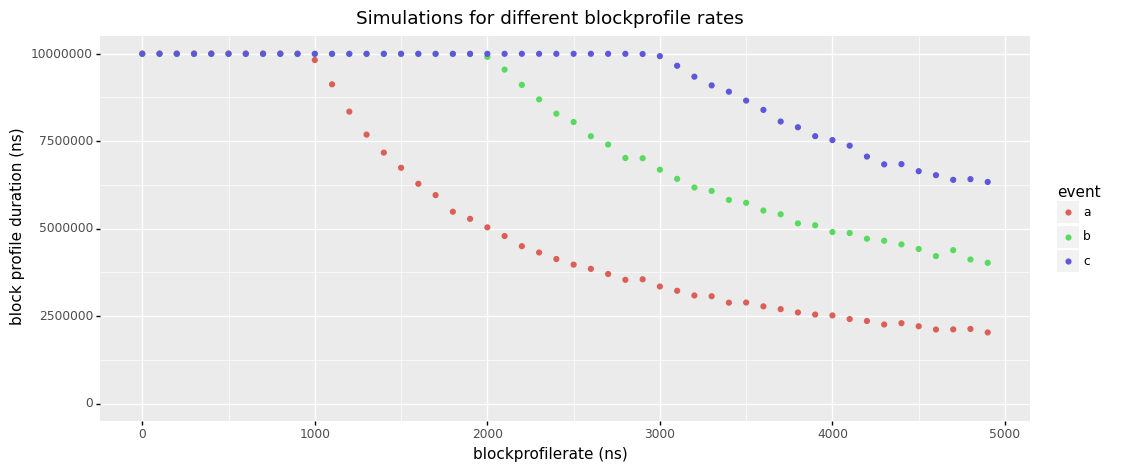

<ggplot: (325120862)>

In [5]:
(
ggplot(profiles)
+ aes(x='rate', y='duration',ymin=0,color='event')
+ labs(y='block profile duration (ns)', x='blockprofilerate (ns)',title='Simulations for different blockprofile rates')
+ geom_point()
)

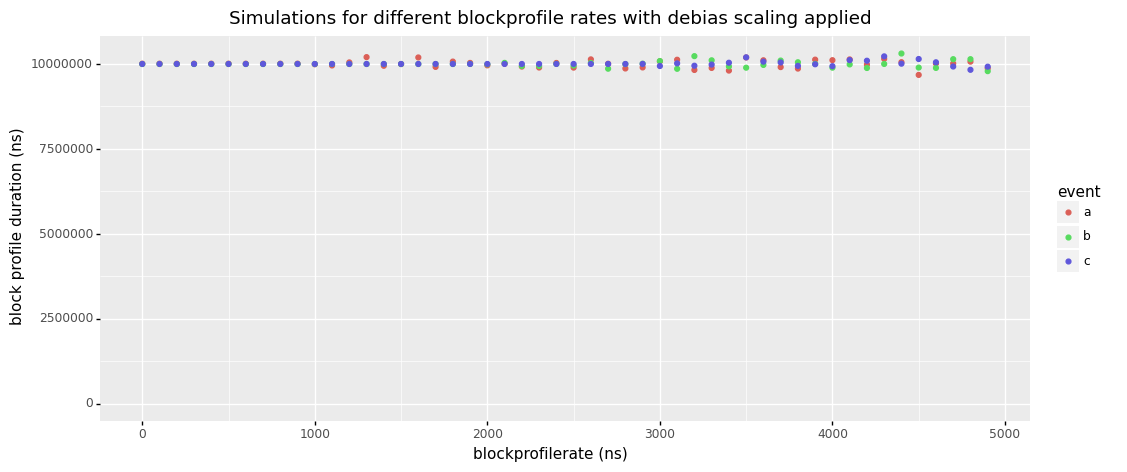

<ggplot: (324948336)>

In [6]:
(
ggplot(profiles_debiased)
+ aes(x='rate', y='duration',ymin=0,color='event')
+ labs(y='block profile duration (ns)', x='blockprofilerate (ns)',title='Simulations for different blockprofile rates with debias scaling applied')
+ geom_point()
)